# CNN solver

In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from torch import nn
import torch.nn.functional as F
from time import time
import contextlib

@contextlib.contextmanager
def timer(msg='timer'):
    tic = time()
    yield
    return print(f"{msg}: {time() - tic:.2f}")

# Neural net solver class

In [27]:
class NeuralNetSolver(nn.Module):
    def __init__(self, T_ini, K, s, device='cpu'):
        super(NeuralNetSolver,self).__init__()
        self.nx = T_ini.shape[2]
        self.ny = T_ini.shape[3]
        self.T = nn.Parameter(T_ini[:,:,1:-1,1:-1])
        self.K = K.to(device)
        self.s = s.to(device)
        dx = 1./(self.nx-1)
        dy = 1./(self.ny-1)
        self.grad_x = torch.tensor([-1./dx, 1./dx]).reshape((1,1,2,1)).to(device)
        self.grad_y = torch.tensor([ 1./dy,-1./dy]).reshape((1,1,1,2)).to(device)
        
        self.avg_x = torch.tensor([.5,.5]).reshape((1,1,2,1)).to(device)
        self.avg_y = torch.tensor([.5,.5]).reshape((1,1,1,2)).to(device)
        
        self.BC_left = torch.zeros((1,1,self.nx-2,1)).to(device)
        self.BC_right = torch.zeros((1,1,self.nx-2,1)).to(device)
        
        self.BC_top = torch.zeros((1,1,1,self.ny)).to(device)
        self.BC_bot = torch.zeros((1,1,1,self.ny)).to(device)
        
    def forward(self):
        T = self.T
        K = self.K
        s = self.s
        
        # Add boundary conditions as padding
        T = self.pad_T()
        
#         print(self.grad_x)
        dT_dx = F.conv2d(T, self.grad_x)
        dT_dy = F.conv2d(T, self.grad_y)
        
        
        
        K_avg_x = F.conv2d(K, self.avg_x)
        K_avg_y = F.conv2d(K, self.avg_y)
        
        
        
        K_d2T_dx2 = F.conv2d(K_avg_x*dT_dx, self.grad_x)
        K_d2T_dy2 = F.conv2d(K_avg_y*dT_dy, self.grad_y)
        
#         print(K_d2T_dx2.shape)
#         print(K_d2T_dy2.shape)
        
        return K_d2T_dx2[:,:,:,1:-1] + K_d2T_dy2[:,:,1:-1,:] + s[:,:,1:-1,1:-1]
    def pad_T(self):
        T = self.T
        T = torch.cat([self.BC_left, T, self.BC_right],dim=3)
        T = torch.cat([self.BC_bot, T, self.BC_top],dim=2)
        return T

In [20]:
def loss_fn(y_hat):
    # note: expected outcome is 0
    return torch.mean((y_hat)**2)

# Training function

In [102]:
def train(net,loss_fn, optimizer, abs_loss_limit, rel_loss_limit, scheduler=None, n_iter=500, n_out=20):
    
    def closure():
        out = net()
        loss = loss_fn(out)
        optimizer.zero_grad()
        loss.backward()
        return loss

      
    last_loss = 0.0
    with timer("solve"):
        print(f"epoch  |  absolute loss  |  relative loss")
        print( "---------------------------------------------")
        for i in range(n_iter):
            loss = optimizer.step(closure)
            if scheduler:
                scheduler.step(loss)
            if (i%n_out)==0:
                with torch.no_grad():
                    loss = loss.item()
                    print(f" {i:04d}       {loss:.2e}          {abs(loss-last_loss):.2e}")
        #         
        #             plt.title(f"epoch = {i:.0f}, loss = {loss:.2e}")
        #             plt.imshow(net.T.reshape(net.T.shape[2:]))
        #             display(fig)
        #             clear_output(wait = True)
                if loss<abs_loss_limit:
                    print(f"Stop! absolute loss target reached ({abs_loss_limit:.2e})")
                    break
                elif abs(loss-last_loss)<rel_loss_limit:
                    print(f"Stop! relative loss target reached ({rel_loss_limit:.2e})")
                    break

                last_loss = loss
    return net.pad_T()

# Simple solver

epoch  |  absolute loss  |  relative loss
---------------------------------------------
 0000       1.00e+00          1.00e+00
 0020       8.08e-01          1.92e-01
 0040       7.22e-01          8.57e-02
 0060       6.23e-01          9.92e-02
 0080       5.91e-01          3.19e-02
 0100       5.55e-01          3.63e-02
 0120       4.88e-01          6.63e-02
 0140       2.65e-02          4.62e-01
 0160       3.19e-03          2.33e-02
 0180       2.00e-03          1.19e-03
 0200       3.96e-04          1.60e-03
 0220       2.62e-04          1.33e-04
 0240       2.34e-04          2.86e-05
 0260       2.30e-04          3.98e-06
 0280       2.26e-04          3.55e-06
 0300       2.25e-04          1.22e-06
 0320       2.23e-04          1.56e-06
 0340       2.21e-04          2.40e-06
 0360       2.18e-04          2.99e-06
 0380       2.12e-04          6.19e-06
 0400       2.12e-04          2.59e-07
 0420       2.10e-04          1.67e-06
 0440       1.39e-04          7.07e-05
 0460       4.2

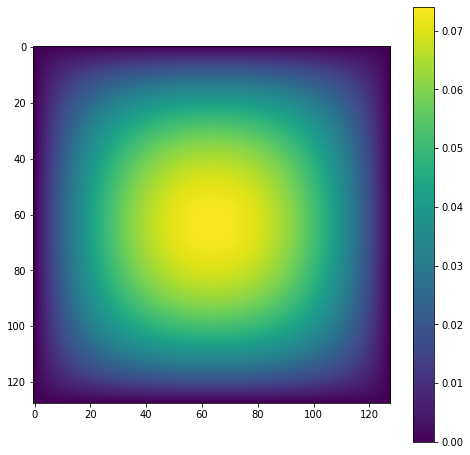

In [36]:
nx = 128
ny = 128
T_ini = torch.zeros((1,1,nx,ny))
K     = torch.ones((1,1,nx,ny))
s     = torch.ones((1,1,nx,ny))
net = NeuralNetSolver(T_ini, K,s)

optimizer = torch.optim.LBFGS(net.parameters())
abs_loss = 1e-10
rel_loss = 1e-100

T_padded = train(net, loss_fn, optimizer, abs_loss, rel_loss)
fig = plt.figure(figsize=[8,8])                
with torch.no_grad():
    plt.imshow(T_padded[0,0,:,:])
    plt.colorbar()
# clear_output(wait = True)

# Multigrid

In [23]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [107]:

n_level = 7 # each level reduces resolution by a factor two
coarse_res = 16
nx, ny = int(coarse_res/2*2**n_level), int(coarse_res/2*2**n_level)
print(nx, ny)
reduction_fac = [2**(n_level-1-level) for level in range(n_level)]
print(reduction_fac)
# Material properties should be defined on the finest grid
K_ref     = torch.ones((1,1,nx,ny))
s_ref     = torch.ones((1,1,nx,ny))

with timer('total'):
    for level, red_fac in enumerate(reduction_fac):
        

        n_iter = 10001
        n_out = 10
        if level<=3:
            device = 'cpu'
        else:
            device = 'cuda'
        if level<n_level-1:
            abs_loss = 1e-4
            rel_loss = 1e-12
            lr = 1.
        else:
            abs_loss = 1e-5
            rel_loss = 1e-7
            lr = 1.0#e-2
        
        with torch.no_grad():
            K = torch.nn.functional.avg_pool2d(K_ref, red_fac, stride=red_fac)
            s = torch.nn.functional.avg_pool2d(s_ref, red_fac, stride=red_fac)

        if level==0:
            T_ini = torch.zeros((1,1,int(nx/red_fac),int(ny/red_fac)))
        else:
            T_ini = F.interpolate(T_previous,scale_factor=2,mode='bilinear',align_corners=True)
        print(T_ini.shape)
        print(device)
                    

        net = NeuralNetSolver(T_ini, K,s,device).to(device)

        optimizer = torch.optim.LBFGS(net.parameters(),lr=lr)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.9)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=int(n_out/2))
        # scheduler = None
        # optimizer = torch.optim.Adam(net.parameters(), lr=5e-3/nx)
        

        
        T_previous = train(net, loss_fn, optimizer, abs_loss, rel_loss, scheduler, n_iter, n_out)

1024 1024
[64, 32, 16, 8, 4, 2, 1]
torch.Size([1, 1, 16, 16])
cpu
epoch  |  absolute loss  |  relative loss
---------------------------------------------
 0000       1.00e+00          1.00e+00
 0010       4.65e-10          1.00e+00
Stop! absolute loss target reached (1.00e-04)
solve: 0.08
torch.Size([1, 1, 32, 32])
cpu
epoch  |  absolute loss  |  relative loss
---------------------------------------------
 0000       3.22e-01          3.22e-01
 0010       1.01e-06          3.22e-01
Stop! absolute loss target reached (1.00e-04)
solve: 0.49
torch.Size([1, 1, 64, 64])
cpu
epoch  |  absolute loss  |  relative loss
---------------------------------------------
 0000       3.26e-01          3.26e-01
 0010       1.35e-05          3.26e-01
Stop! absolute loss target reached (1.00e-04)
solve: 0.55
torch.Size([1, 1, 128, 128])
cpu
epoch  |  absolute loss  |  relative loss
---------------------------------------------
 0000       3.28e-01          3.28e-01
 0010       2.26e-05          3.28e-01
S

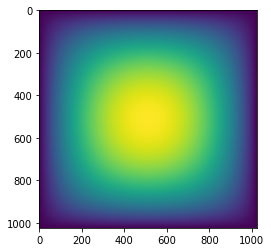

In [110]:
with torch.no_grad():
    plt.imshow(T_previous.to('cpu')[0,0,:,:])

In [81]:
torch.mean(torch.abs(net()))

tensor(0.0242, device='cuda:0', grad_fn=<MeanBackward0>)